In [49]:
# Imports
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt

In [50]:
#make sure we are running off of the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu");
print(device)

cuda:0


In [51]:
# Settings to use for both model
beta_1 = 0.0
betas = [0.8, 0.9, 0.95, 0.99]
batchsize = 8
batchSizes = [8, 16, 32]
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Main code
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_some_pictures(j ):
    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(j)))


def random_test():
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # print images
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

    net = Net()
    net.load_state_dict(torch.load(PATH))
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(4)))

def train(net, noe, filepath_trainloss, filepath_testacc, filepath_trainacc, initial_lr,  batchsize, device):
    doc = open(filepath_trainloss+'.txt', "w")
    doc2 = open(filepath_testacc+'.txt', "w")
    doc3 = open(filepath_trainacc+'.txt', "w")
    check_interval=1000
    batch_number = int(6000*8/(batchsize*check_interval))
    # print(batch_number)
    training_loss_vec = [] #np.zeros(noe*check_interval)
    train_acc_vec = [] #np.zeros(noe*check_interval)
    test_acc_vec = [] #np.zeros(noe*check_interval)
    for epoch in range(noe):  # loop over the dataset multiple times
        time_begin  = time.time()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % check_interval == (check_interval-1):    # print every 2000 mini-batches
                time_end = time.time()
                time_elapsed = time_end - time_begin
                time_begin = time.time()
                print('[%d, %5d] loss: %.3f, Time Taken %.3f' %
                      (epoch + 1, i + 1, running_loss / check_interval, time_elapsed))
                running_loss = 0.0
        if epoch % 20 == 0:
            time_end = time.time()
            time_elapsed = time_end - time_begin
            time_begin = time.time()
            print("\tTesting Time: ", time_elapsed)
            training_loss_vec.append(running_loss/check_interval)
            train_acc = train_accuracy(net)
            train_acc_vec.append(train_acc)
            test_acc = test_accuracy(net)
            test_acc_vec.append(test_acc)
            print(running_loss / check_interval, file=doc)
            print(test_acc, file=doc2)
            print(train_acc, file=doc3)
        if epoch % 1 == 0:
            for p in optimizer.param_groups:
                p['lr'] = initial_lr/np.sqrt(1+epoch)
    training_loss_vec.append(running_loss/check_interval)
    train_acc = train_accuracy(net)
    train_acc_vec.append(train_acc)
    test_acc = test_accuracy(net)
    test_acc_vec.append(test_acc)
    print(running_loss / check_interval, file=doc)
    print(test_acc, file=doc2)
    print(train_acc, file=doc3)
    doc.close()
    doc2.close()

    xvar = np.arange(len(training_loss_vec)) * 20
    plt.figure(1)
    plt.title("Training Loss", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training loss')
    plt.plot(xvar, np.array(training_loss_vec))
    plt.savefig(filepath_trainloss+'.png')

    plt.figure(2)
    plt.title("Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('test accuracy(%)')
    plt.plot(xvar, np.array(test_acc_vec), label="Test accuracy")
    plt.legend()
    plt.savefig(filepath_testacc + '.png')

    plt.figure(2)
    plt.title("Training and Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training accuracy(%)')
    plt.plot(xvar, np.array(train_acc_vec), label="Training accuracy")
    plt.legend()
    plt.savefig(filepath_trainacc + '.png')

def train_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def test_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total



Files already downloaded and verified
Files already downloaded and verified


Using cache found in C:\Users\Aria/.cache\torch\hub\pytorch_vision_v0.6.0
c:\Users\Aria\Desktop\CS536FinalProject\gpu_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Aria\Desktop\CS536FinalProject\gpu_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in C:\Users\Aria/.cache\torch\hub\pytorch_vision_v0.6.0


[1,  1000] loss: 2.195, Time Taken 33.560
[1,  2000] loss: 1.921, Time Taken 8.448
[1,  3000] loss: 1.804, Time Taken 8.450
[1,  4000] loss: 1.736, Time Taken 8.472
[1,  5000] loss: 1.695, Time Taken 8.349
[1,  6000] loss: 1.608, Time Taken 8.412
	Testing Time:  2.741490364074707
[2,  1000] loss: 1.561, Time Taken 33.984
[2,  2000] loss: 1.544, Time Taken 8.664
[2,  3000] loss: 1.503, Time Taken 8.619
[2,  4000] loss: 1.520, Time Taken 8.624
[2,  5000] loss: 1.468, Time Taken 8.716
[2,  6000] loss: 1.431, Time Taken 8.733
[3,  1000] loss: 1.259, Time Taken 34.968
[3,  2000] loss: 1.280, Time Taken 9.091
[3,  3000] loss: 1.249, Time Taken 8.953
[3,  4000] loss: 1.289, Time Taken 8.803
[3,  5000] loss: 1.292, Time Taken 9.070
[3,  6000] loss: 1.249, Time Taken 8.947
[4,  1000] loss: 1.146, Time Taken 34.618
[4,  2000] loss: 1.183, Time Taken 8.795
[4,  3000] loss: 1.116, Time Taken 8.878
[4,  4000] loss: 1.192, Time Taken 8.823
[4,  5000] loss: 1.161, Time Taken 8.861
[4,  6000] loss: 1.

Using cache found in C:\Users\Aria/.cache\torch\hub\pytorch_vision_v0.6.0


[1,  1000] loss: 1.894, Time Taken 32.889
[1,  2000] loss: 1.532, Time Taken 8.440
[1,  3000] loss: 1.383, Time Taken 8.471
	Testing Time:  1.6193630695343018
[2,  1000] loss: 1.266, Time Taken 33.105
[2,  2000] loss: 1.198, Time Taken 8.438
[2,  3000] loss: 1.164, Time Taken 8.435
[3,  1000] loss: 0.993, Time Taken 32.893
[3,  2000] loss: 0.985, Time Taken 8.446
[3,  3000] loss: 0.980, Time Taken 8.420
[4,  1000] loss: 0.849, Time Taken 32.684
[4,  2000] loss: 0.879, Time Taken 8.453
[4,  3000] loss: 0.856, Time Taken 8.447
[5,  1000] loss: 0.774, Time Taken 33.056
[5,  2000] loss: 0.767, Time Taken 8.407
[5,  3000] loss: 0.778, Time Taken 8.420
[6,  1000] loss: 0.701, Time Taken 32.792
[6,  2000] loss: 0.691, Time Taken 8.428
[6,  3000] loss: 0.732, Time Taken 8.468
[7,  1000] loss: 0.635, Time Taken 32.965
[7,  2000] loss: 0.636, Time Taken 8.418
[7,  3000] loss: 0.663, Time Taken 8.405
[8,  1000] loss: 0.556, Time Taken 33.169
[8,  2000] loss: 0.585, Time Taken 8.244
[8,  3000] los

Using cache found in C:\Users\Aria/.cache\torch\hub\pytorch_vision_v0.6.0


[1,  1000] loss: 1.621, Time Taken 33.168
	Testing Time:  5.3887939453125
[2,  1000] loss: 1.086, Time Taken 32.743
[3,  1000] loss: 0.835, Time Taken 33.068
[4,  1000] loss: 0.693, Time Taken 33.470
[5,  1000] loss: 0.560, Time Taken 32.941
[6,  1000] loss: 0.477, Time Taken 33.220
[7,  1000] loss: 0.410, Time Taken 33.256
[8,  1000] loss: 0.331, Time Taken 32.823
[9,  1000] loss: 0.272, Time Taken 33.046
[10,  1000] loss: 0.216, Time Taken 33.113
[11,  1000] loss: 0.181, Time Taken 32.829
[12,  1000] loss: 0.151, Time Taken 33.229
[13,  1000] loss: 0.128, Time Taken 33.030
[14,  1000] loss: 0.103, Time Taken 32.839
[15,  1000] loss: 0.088, Time Taken 33.086
[16,  1000] loss: 0.075, Time Taken 33.035
[17,  1000] loss: 0.083, Time Taken 32.965
[18,  1000] loss: 0.067, Time Taken 32.989
[19,  1000] loss: 0.056, Time Taken 33.016
[20,  1000] loss: 0.051, Time Taken 32.987
[21,  1000] loss: 0.049, Time Taken 33.107
	Testing Time:  5.329193592071533
[22,  1000] loss: 0.042, Time Taken 32.8

Using cache found in C:\Users\Aria/.cache\torch\hub\pytorch_vision_v0.6.0


[1,  1000] loss: 2.181, Time Taken 32.940
[1,  2000] loss: 1.922, Time Taken 8.450
[1,  3000] loss: 1.791, Time Taken 8.441
[1,  4000] loss: 1.680, Time Taken 8.437
[1,  5000] loss: 1.585, Time Taken 8.456
[1,  6000] loss: 1.553, Time Taken 8.464
	Testing Time:  2.719111680984497
[2,  1000] loss: 1.472, Time Taken 33.054
[2,  2000] loss: 1.430, Time Taken 8.398
[2,  3000] loss: 1.378, Time Taken 8.419
[2,  4000] loss: 1.369, Time Taken 8.413
[2,  5000] loss: 1.378, Time Taken 8.404
[2,  6000] loss: 1.347, Time Taken 8.382
[3,  1000] loss: 1.222, Time Taken 32.917
[3,  2000] loss: 1.194, Time Taken 8.406
[3,  3000] loss: 1.179, Time Taken 8.410
[3,  4000] loss: 1.165, Time Taken 8.392
[3,  5000] loss: 1.164, Time Taken 8.379
[3,  6000] loss: 1.144, Time Taken 8.374
[4,  1000] loss: 1.064, Time Taken 33.110
[4,  2000] loss: 1.065, Time Taken 8.368
[4,  3000] loss: 1.061, Time Taken 8.373
[4,  4000] loss: 1.048, Time Taken 8.379
[4,  5000] loss: 1.065, Time Taken 8.342
[4,  6000] loss: 1.

Using cache found in C:\Users\Aria/.cache\torch\hub\pytorch_vision_v0.6.0


[1,  1000] loss: 1.895, Time Taken 32.977
[1,  2000] loss: 1.556, Time Taken 8.464
[1,  3000] loss: 1.365, Time Taken 8.445
	Testing Time:  1.625364065170288
[2,  1000] loss: 1.239, Time Taken 33.152
[2,  2000] loss: 1.160, Time Taken 8.448
[2,  3000] loss: 1.109, Time Taken 8.443
[3,  1000] loss: 0.941, Time Taken 33.028
[3,  2000] loss: 0.918, Time Taken 8.431
[3,  3000] loss: 0.906, Time Taken 8.418
[4,  1000] loss: 0.798, Time Taken 33.123
[4,  2000] loss: 0.803, Time Taken 8.450
[4,  3000] loss: 0.764, Time Taken 8.469
[5,  1000] loss: 0.691, Time Taken 33.210
[5,  2000] loss: 0.696, Time Taken 8.438
[5,  3000] loss: 0.703, Time Taken 8.337
[6,  1000] loss: 0.604, Time Taken 32.969
[6,  2000] loss: 0.610, Time Taken 8.423
[6,  3000] loss: 0.616, Time Taken 8.416
[7,  1000] loss: 0.519, Time Taken 32.978
[7,  2000] loss: 0.532, Time Taken 8.453
[7,  3000] loss: 0.561, Time Taken 8.467
[8,  1000] loss: 0.465, Time Taken 32.859
[8,  2000] loss: 0.471, Time Taken 8.469
[8,  3000] loss

Using cache found in C:\Users\Aria/.cache\torch\hub\pytorch_vision_v0.6.0


[1,  1000] loss: 1.599, Time Taken 37.982
	Testing Time:  5.6071319580078125
[2,  1000] loss: 1.051, Time Taken 34.101
[3,  1000] loss: 0.798, Time Taken 34.658
[4,  1000] loss: 0.641, Time Taken 35.074
[5,  1000] loss: 0.528, Time Taken 34.501
[6,  1000] loss: 0.431, Time Taken 34.621
[7,  1000] loss: 0.335, Time Taken 34.608
[8,  1000] loss: 0.272, Time Taken 34.550
[9,  1000] loss: 0.208, Time Taken 34.639
[10,  1000] loss: 0.167, Time Taken 34.336
[11,  1000] loss: 0.130, Time Taken 34.397
[12,  1000] loss: 0.100, Time Taken 34.113
[13,  1000] loss: 0.087, Time Taken 34.157
[14,  1000] loss: 0.071, Time Taken 35.029
[15,  1000] loss: 0.062, Time Taken 35.347
[16,  1000] loss: 0.055, Time Taken 34.761
[17,  1000] loss: 0.051, Time Taken 34.042
[18,  1000] loss: 0.048, Time Taken 33.947
[19,  1000] loss: 0.038, Time Taken 33.874
[20,  1000] loss: 0.040, Time Taken 33.685
[21,  1000] loss: 0.038, Time Taken 33.880
	Testing Time:  5.592687606811523
[22,  1000] loss: 0.029, Time Taken 3

Using cache found in C:\Users\Aria/.cache\torch\hub\pytorch_vision_v0.6.0


[1,  1000] loss: 2.230, Time Taken 35.015
[1,  2000] loss: 1.852, Time Taken 9.087
[1,  3000] loss: 1.743, Time Taken 9.118
[1,  4000] loss: 1.645, Time Taken 9.073
[1,  5000] loss: 1.549, Time Taken 9.073
[1,  6000] loss: 1.483, Time Taken 9.131
	Testing Time:  2.9356868267059326
[2,  1000] loss: 1.418, Time Taken 35.607
[2,  2000] loss: 1.331, Time Taken 9.340
[2,  3000] loss: 1.318, Time Taken 9.667
[2,  4000] loss: 1.288, Time Taken 9.026
[2,  5000] loss: 1.270, Time Taken 9.072
[2,  6000] loss: 1.235, Time Taken 9.061
[3,  1000] loss: 1.123, Time Taken 35.851
[3,  2000] loss: 1.059, Time Taken 9.189
[3,  3000] loss: 1.058, Time Taken 9.200
[3,  4000] loss: 1.044, Time Taken 9.189
[3,  5000] loss: 1.056, Time Taken 9.383
[3,  6000] loss: 1.027, Time Taken 9.352
[4,  1000] loss: 0.948, Time Taken 35.816
[4,  2000] loss: 0.941, Time Taken 9.254
[4,  3000] loss: 0.931, Time Taken 9.321
[4,  4000] loss: 0.951, Time Taken 9.250
[4,  5000] loss: 0.942, Time Taken 9.134
[4,  6000] loss: 0

Using cache found in C:\Users\Aria/.cache\torch\hub\pytorch_vision_v0.6.0


[1,  1000] loss: 1.884, Time Taken 33.876
[1,  2000] loss: 1.480, Time Taken 8.863
[1,  3000] loss: 1.314, Time Taken 8.938
	Testing Time:  1.7068114280700684
[2,  1000] loss: 1.156, Time Taken 34.009
[2,  2000] loss: 1.101, Time Taken 8.822
[2,  3000] loss: 1.071, Time Taken 8.902
[3,  1000] loss: 0.883, Time Taken 33.847
[3,  2000] loss: 0.867, Time Taken 8.892
[3,  3000] loss: 0.853, Time Taken 8.878
[4,  1000] loss: 0.732, Time Taken 33.963
[4,  2000] loss: 0.714, Time Taken 8.839
[4,  3000] loss: 0.712, Time Taken 8.847
[5,  1000] loss: 0.615, Time Taken 33.903
[5,  2000] loss: 0.606, Time Taken 8.906
[5,  3000] loss: 0.620, Time Taken 8.901
[6,  1000] loss: 0.516, Time Taken 33.807
[6,  2000] loss: 0.512, Time Taken 8.865
[6,  3000] loss: 0.535, Time Taken 8.908
[7,  1000] loss: 0.417, Time Taken 33.783
[7,  2000] loss: 0.449, Time Taken 8.887
[7,  3000] loss: 0.452, Time Taken 8.880
[8,  1000] loss: 0.357, Time Taken 34.214
[8,  2000] loss: 0.355, Time Taken 8.880
[8,  3000] los

Using cache found in C:\Users\Aria/.cache\torch\hub\pytorch_vision_v0.6.0


[1,  1000] loss: 1.609, Time Taken 33.914
	Testing Time:  5.639181852340698
[2,  1000] loss: 1.031, Time Taken 33.835
[3,  1000] loss: 0.772, Time Taken 33.924
[4,  1000] loss: 0.602, Time Taken 34.168
[5,  1000] loss: 0.486, Time Taken 33.789
[6,  1000] loss: 0.380, Time Taken 34.061
[7,  1000] loss: 0.296, Time Taken 34.040
[8,  1000] loss: 0.219, Time Taken 33.824
[9,  1000] loss: 0.172, Time Taken 33.930
[10,  1000] loss: 0.126, Time Taken 34.089
[11,  1000] loss: 0.101, Time Taken 33.988
[12,  1000] loss: 0.084, Time Taken 34.151
[13,  1000] loss: 0.066, Time Taken 34.076
[14,  1000] loss: 0.061, Time Taken 33.786
[15,  1000] loss: 0.052, Time Taken 34.041
[16,  1000] loss: 0.046, Time Taken 34.114
[17,  1000] loss: 0.041, Time Taken 33.858
[18,  1000] loss: 0.037, Time Taken 34.217
[19,  1000] loss: 0.032, Time Taken 34.007
[20,  1000] loss: 0.030, Time Taken 33.919
[21,  1000] loss: 0.029, Time Taken 34.069
	Testing Time:  5.614464998245239
[22,  1000] loss: 0.023, Time Taken 33

Using cache found in C:\Users\Aria/.cache\torch\hub\pytorch_vision_v0.6.0


[1,  1000] loss: 2.215, Time Taken 33.454
[1,  2000] loss: 1.899, Time Taken 8.761
[1,  3000] loss: 1.758, Time Taken 8.723
[1,  4000] loss: 1.611, Time Taken 8.728
[1,  5000] loss: 1.544, Time Taken 8.706
[1,  6000] loss: 1.477, Time Taken 8.709
	Testing Time:  2.8137049674987793
[2,  1000] loss: 1.404, Time Taken 33.687
[2,  2000] loss: 1.327, Time Taken 8.718
[2,  3000] loss: 1.308, Time Taken 8.693
[2,  4000] loss: 1.263, Time Taken 8.711
[2,  5000] loss: 1.216, Time Taken 8.773
[2,  6000] loss: 1.171, Time Taken 8.748
[3,  1000] loss: 1.050, Time Taken 33.525
[3,  2000] loss: 1.037, Time Taken 8.787
[3,  3000] loss: 0.991, Time Taken 8.793
[3,  4000] loss: 1.009, Time Taken 8.793
[3,  5000] loss: 0.945, Time Taken 8.716
[3,  6000] loss: 0.949, Time Taken 8.758
[4,  1000] loss: 0.860, Time Taken 33.991
[4,  2000] loss: 0.843, Time Taken 8.761
[4,  3000] loss: 0.849, Time Taken 8.646
[4,  4000] loss: 0.829, Time Taken 8.710
[4,  5000] loss: 0.815, Time Taken 8.733
[4,  6000] loss: 0

Using cache found in C:\Users\Aria/.cache\torch\hub\pytorch_vision_v0.6.0


[1,  1000] loss: 1.853, Time Taken 33.604
[1,  2000] loss: 1.466, Time Taken 8.815
[1,  3000] loss: 1.293, Time Taken 8.831
	Testing Time:  1.7264528274536133
[2,  1000] loss: 1.132, Time Taken 33.566
[2,  2000] loss: 1.063, Time Taken 8.822
[2,  3000] loss: 1.005, Time Taken 8.864
[3,  1000] loss: 0.828, Time Taken 33.969
[3,  2000] loss: 0.800, Time Taken 8.859
[3,  3000] loss: 0.789, Time Taken 8.841
[4,  1000] loss: 0.649, Time Taken 33.642
[4,  2000] loss: 0.653, Time Taken 8.869
[4,  3000] loss: 0.654, Time Taken 8.854
[5,  1000] loss: 0.529, Time Taken 33.775
[5,  2000] loss: 0.530, Time Taken 8.845
[5,  3000] loss: 0.542, Time Taken 8.814
[6,  1000] loss: 0.417, Time Taken 34.059
[6,  2000] loss: 0.430, Time Taken 8.767
[6,  3000] loss: 0.441, Time Taken 8.807
[7,  1000] loss: 0.329, Time Taken 33.916
[7,  2000] loss: 0.339, Time Taken 8.828
[7,  3000] loss: 0.360, Time Taken 8.837
[8,  1000] loss: 0.255, Time Taken 33.878
[8,  2000] loss: 0.268, Time Taken 8.854
[8,  3000] los

Using cache found in C:\Users\Aria/.cache\torch\hub\pytorch_vision_v0.6.0


[1,  1000] loss: 1.602, Time Taken 33.785
	Testing Time:  5.633769512176514
[2,  1000] loss: 1.041, Time Taken 33.543


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002727FD9B380>
Traceback (most recent call last):
  File "c:\Users\Aria\Desktop\CS536FinalProject\gpu_env\Lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "c:\Users\Aria\Desktop\CS536FinalProject\gpu_env\Lib\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002727FD9B380>
Traceback (most recent call last):
  File "c:\Users\Aria\Desktop\CS536FinalProject\gpu_env\Lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "c:\Users\Aria\Desktop\CS536FinalProject\gpu_env\Lib\site-package

[3,  1000] loss: 0.765, Time Taken 34.752
[4,  1000] loss: 0.592, Time Taken 33.900
[5,  1000] loss: 0.467, Time Taken 33.689
[6,  1000] loss: 0.347, Time Taken 33.914
[7,  1000] loss: 0.256, Time Taken 33.908
[8,  1000] loss: 0.180, Time Taken 33.773
[9,  1000] loss: 0.134, Time Taken 33.918
[10,  1000] loss: 0.105, Time Taken 33.926
[11,  1000] loss: 0.079, Time Taken 33.918
[12,  1000] loss: 0.070, Time Taken 33.936
[13,  1000] loss: 0.058, Time Taken 33.938
[14,  1000] loss: 0.049, Time Taken 33.816
[15,  1000] loss: 0.043, Time Taken 34.132
[16,  1000] loss: 0.037, Time Taken 33.939
[17,  1000] loss: 0.033, Time Taken 33.699
[18,  1000] loss: 0.031, Time Taken 33.735
[19,  1000] loss: 0.027, Time Taken 33.907
[20,  1000] loss: 0.024, Time Taken 33.592
[21,  1000] loss: 0.025, Time Taken 33.941
	Testing Time:  5.6253931522369385
[22,  1000] loss: 0.022, Time Taken 33.602
[23,  1000] loss: 0.022, Time Taken 33.948
[24,  1000] loss: 0.019, Time Taken 33.964
[25,  1000] loss: 0.018, T

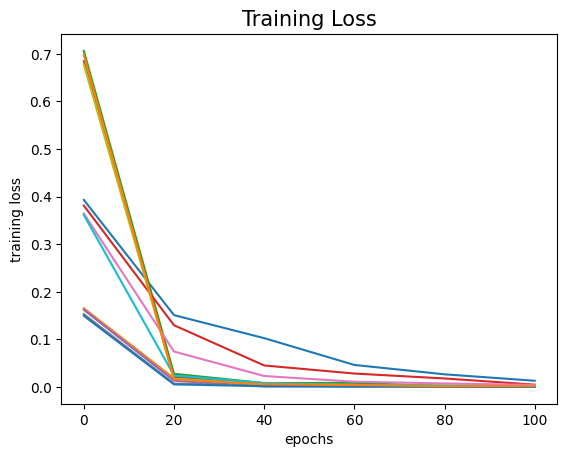

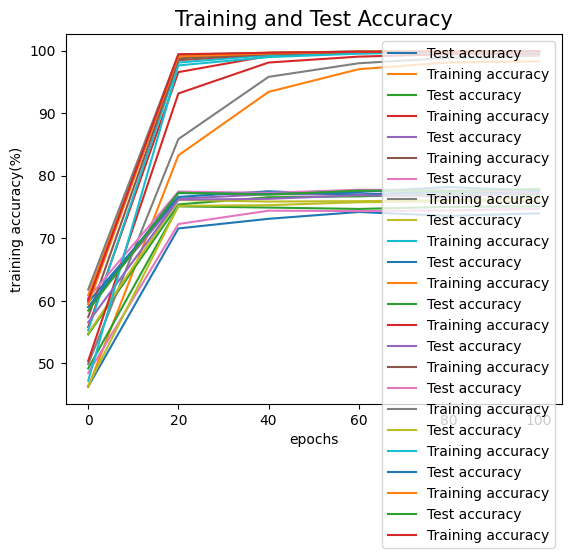

In [55]:
# data sets
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
# resnet
net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)
net = net.to(device)
net.eval()
# # cifar_resnet.py
criterion = nn.CrossEntropyLoss()
PATH = './cifar_net_Adam.pth'
for beta in betas:
    beta_2 = beta
    for batchSize in batchSizes:
        batchsize = batchSize
        net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)
        net = net.to(device)
        optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(beta_1, beta), eps=1e-08, weight_decay=0, amsgrad=False)

        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=8,  pin_memory=True)

        testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                         shuffle=False, num_workers=8,  pin_memory=True)
        train(net, epochs, "Exp1-training-loss-beta1="+str(beta_1)+";beta2="+str(beta)+";bs="+str(batchSize), "Exp1-test-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-train-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), 0.001, batchsize, device)
        torch.save(net.state_dict(), PATH)
print('Finished Training')

In [ ]:
# cifar_resnet_SGD.py
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=beta_1, dampening=0, weight_decay=0, nesterov=False)
PATH = './cifar_net_SGD.pth'
for batchSize in batchSizes:
    train(net, epochs, "Exp1-training-loss-beta1="+str(beta_1)+";bs="+str(batchSize), "Exp1-test-accuracy-beta1="+str(beta_1)+";bs="+str(batchSize), "Exp1-train-accuracy-beta1="+str(beta_1)+";bs="+str(batchSize), 0.001, batchSize, device)
    torch.save(net.state_dict(), PATH)
print('Finished Training')